In [1]:
pip install scikit-fuzzy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade scipy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Paths to data
train_dir = 'C:/Users/HP/Downloads/archive (1)/chest_xray/train'
test_dir = 'C:/Users/HP/Downloads/archive (1)/chest_xray/test'

# Image augmentation for training data
train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Test data preparation
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


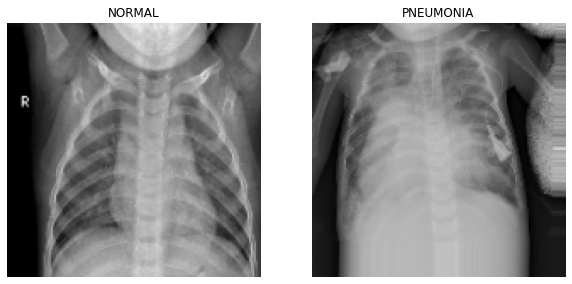

In [13]:
#  Verify class indices
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Display a sample image from each category
fig, axes = plt.subplots(1, len(class_names), figsize=(10, 5))
for i, class_name in enumerate(class_names):
    # Select one image from each class
    for images, labels in train_generator:
        if labels[0] == i:
            axes[i].imshow(images[0])
            axes[i].set_title(class_name)
            axes[i].axis('off')
            break

plt.show()

In [14]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

In [18]:
# Compile the model
model = create_model()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,  # Use the correct generator here
    epochs=3,
    validation_data=test_data
)

Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 780ms/step - accuracy: 0.7632 - loss: 0.5546 - val_accuracy: 0.7788 - val_loss: 0.5048
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 671ms/step - accuracy: 0.8877 - loss: 0.2597 - val_accuracy: 0.7420 - val_loss: 0.7459
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 726ms/step - accuracy: 0.9175 - loss: 0.2164 - val_accuracy: 0.8125 - val_loss: 0.4228


In [19]:
def fuzzy_decision(probability):
    # Define fuzzy membership functions for probability
    x_prob = np.arange(0, 1.01, 0.01)

    # Membership functions for probability
    prob_low = fuzz.trapmf(x_prob, [0.0, 0.0, 0.3, 0.5])
    prob_medium = fuzz.trimf(x_prob, [0.3, 0.5, 0.7])
    prob_high = fuzz.trapmf(x_prob, [0.5, 0.7, 1.0, 1.0])

    # Fuzzy membership values for the input probability
    prob_level_low = fuzz.interp_membership(x_prob, prob_low, probability)
    prob_level_medium = fuzz.interp_membership(x_prob, prob_medium, probability)
    prob_level_high = fuzz.interp_membership(x_prob, prob_high, probability)

    # Fuzzy rules
    if prob_level_high > max(prob_level_low, prob_level_medium):
        return 'Pneumonia'
    elif prob_level_low > max(prob_level_high, prob_level_medium):
        return 'Normal'
    else:
        return 'Uncertain'


In [20]:
# Evaluate each image in the test set
predictions = model.predict(test_data)

# Apply fuzzy logic for decision-making
for i, pred in enumerate(predictions):
    probability = pred[0]  # Extract probability
    decision = fuzzy_decision(probability)
    print(f"Image {i+1}: Probability = {probability:.2f}, Decision = {decision}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step
Image 1: Probability = 1.00, Decision = Pneumonia
Image 2: Probability = 0.93, Decision = Pneumonia
Image 3: Probability = 0.95, Decision = Pneumonia
Image 4: Probability = 0.08, Decision = Normal
Image 5: Probability = 0.77, Decision = Pneumonia
Image 6: Probability = 0.43, Decision = Uncertain
Image 7: Probability = 0.99, Decision = Pneumonia
Image 8: Probability = 0.93, Decision = Pneumonia
Image 9: Probability = 0.59, Decision = Uncertain
Image 10: Probability = 0.96, Decision = Pneumonia
Image 11: Probability = 1.00, Decision = Pneumonia
Image 12: Probability = 0.54, Decision = Uncertain
Image 13: Probability = 1.00, Decision = Pneumonia
Image 14: Probability = 0.20, Decision = Normal
Image 15: Probability = 1.00, Decision = Pneumonia
Image 16: Probability = 0.93, Decision = Pneumonia
Image 17: Probability = 0.96, Decision = Pneumonia
Image 18: Probability = 0.99, Decision = Pneumonia
Image 19: Probability = 0.99, Decision = Pneumonia
Image

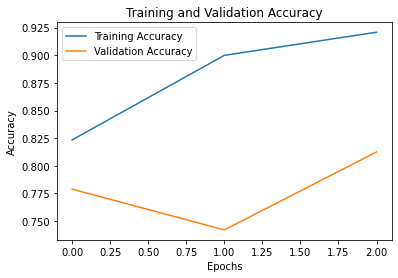

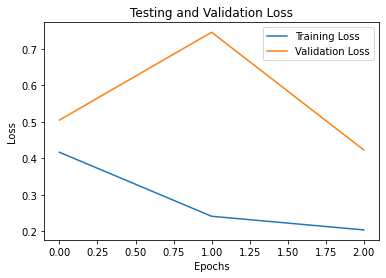

In [40]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Testing and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.8056 - loss: 0.4136
Test Accuracy: 81.25%
Test Loss: 42.28%


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step


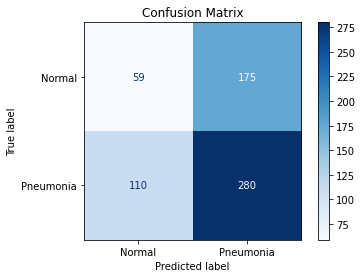

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Assuming test_data is the test dataset generator
predictions = model.predict(test_data)
y_pred = [1 if fuzzy_decision(pred[0]) == 'Pneumonia' else 0 for pred in predictions]

# Obtain true labels
y_true = test_data.classes  # True labels from the generator

# Display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [28]:
from sklearn.metrics import classification_report,confusion_matrix

In [36]:
from sklearn.metrics import classification_report

# Generate predictions on the test data
test_data.reset()  # Reset the generator to avoid issues if already iterated
y_pred_prob = model.predict(test_data)
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary class labels (0 or 1)

# True labels from the test generator
y_true = test_data.classes  # True class labels

# Class names (e.g., 'class_0', 'class_1')
class_names = list(test_data.class_indices.keys())

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step
              precision    recall  f1-score   support

      NORMAL       0.36      0.22      0.27       234
   PNEUMONIA       0.62      0.76      0.68       390

    accuracy                           0.56       624
   macro avg       0.49      0.49      0.48       624
weighted avg       0.52      0.56      0.53       624

